In [1]:
## Import Libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import os
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (15,10)
3

3

In [2]:
os.chdir('/home/cht104/data_q2/40_5000_320_500')


In [50]:
'''
the data (x) is a 1 dimentional numpy array of the 1->2 packets
'''
class MAD_model():
    '''
    inputs
    window_size: size of window to shift over
    thresh_height: height of the threshold to detect an anomaly on
    '''
    def __init__(self, window_size, thresh_height=100):
        self.window_size = window_size
        self.thresh = thresh_height / (window_size / 100)
        self.window = np.zeros(window_size)
        # median, median absolute deviation and deviation from median if needed later
        # for the most recent data passed into rolling_stats
        self.median = None
        self.mad = None
        self.dm = None
    
    '''
    Computes the rolling MAD, Median and average deviation from the median
    returns transform: a function of the 3 stats above
    '''
    def rolling_stats(self, x):
        mad_f = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)
        
        median = []
        dm = []
        mad = []
        
        for i in range(len(x)-self.window_size):
            subset = x[i:i+self.window_size]
            m = np.median(subset)
            median = median + [m]
            dm = dm + [np.sum((subset-m))/self.window_size]
            mad = mad + [mad_f(subset)]
        
        transform = np.array(mad)*dm / median
        self.median = median
        self.mad = mad
        self.dm = dm
        
        return transform
    
    '''
    detects an anomaly if the function of median, mad and dm are above a certain threshold
    return the indexes of where the anomaly is, already adjusted to the window size
    '''
    def detect_anomaly(self, x):
        transform = self.rolling_stats(x)
        
        index = np.arange(len(transform))
        anomaly_index = index[(transform > self.thresh)] + self.window_size // 2
        
        return anomaly_index
    
    '''
    plots the data and anomolous region detected given the data and conditions
    '''
    def plot_region(self, x, conditions, shift_time=None,  filepath=None):
        anom_region = self.detect_anomaly(x)
        
        plt.plot(x, label='1->2pkts')
        
        plt.vlines(anom_region, min(x), max(x), colors='C3', alpha=.2)
        
        if shift_time != None:
            plt.vlines(180, 0, max(x), colors='C3')
        
        plt.title(f'1->2 packets, conditions: {conditions}')
        plt.ylabel('packets')
        plt.xlabel('time')    
        plt.legend()
        
        if filepath != None:
            plt.savefig(filepath)
def arima_model_anomalies(data):
    rmse, model, test, preds,anomalies,upper,lower = eval_arima(np.log(data.astype('float')),(3,0,2),.01,75)
    return anomalies

def MAD_anomalies(data):
    X = np.array(data)
    model = MAD_model(80)
    anomalies_indexes = model.detect_anomaly(X)
    binary_anomaly_list = []
    for i in range(len(data)):
        if i in anomalies_indexes:
            binary_anomaly_list.append(1)
        else:
            binary_anomaly_list.append(0)
            
    return binary_anomaly_list

def anomaly_ensemble(model1, model2, data1, data2,window):
    DF = data1.copy()
    df = data2.copy()
    arima_anomalies = model2(DF.total_pkts)
    DF['anomaly'] = list(np.zeros(shape=(1,len(DF)-len(arima_anomalies)))[0]) + arima_anomalies
    df['anomaly'] = 0
    count = window
    for i in range(len(DF)):
        if DF.loc[i,'anomaly'] == 1:
            df.loc[(i*window):(i*window)+window,'anomaly'] = 1
    mad = model1(df.total_pkts)
    all_anom = df.anomaly
    final_preds = []
    for i in range(len(df)):
        if mad[i] == 1 and all_anom[i] ==1:
            final_preds.append(1)
        else:
            final_preds.append(0)
    return final_preds

def plot_ensemble_results(preds, data):
    df = data.copy()
    df['final_a'] = preds
    anom = df[df.final_a==1]
    plt.plot(df.total_pkts,label='Total Packets')
    plt.scatter(anom.index,anom.total_pkts,color='r',label='anomaly')
    plt.xlabel('Time(s)')
    plt.ylabel('Total Packets')
    plt.title('Ensemble Anomaly Detection Output')
    plt.legend()
    plt.savefig('output.png', dpi=300)


In [48]:
preds = anomaly_ensemble(MAD_anomalies,arima_model_anomalies,DF,df,20)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


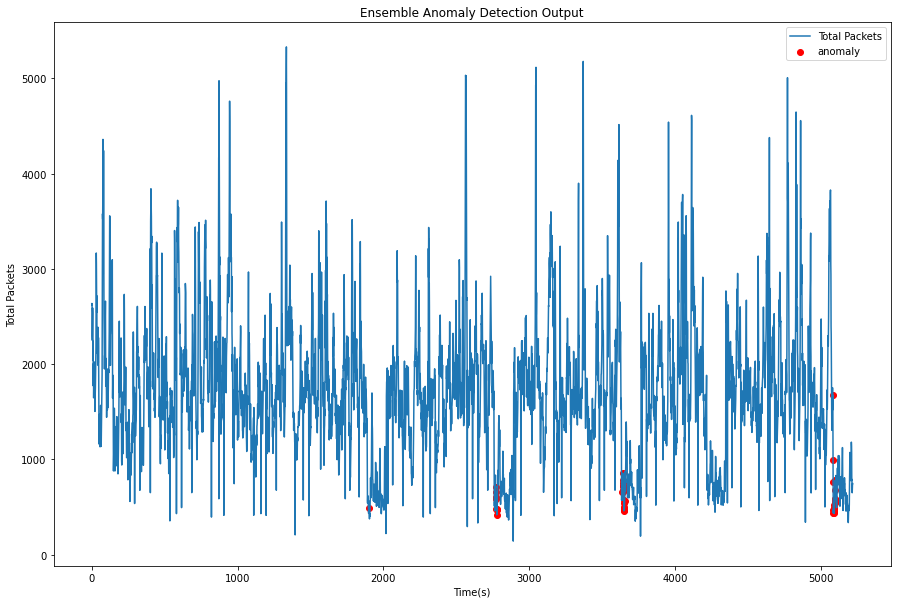

In [51]:
plot_ensemble_results(preds,df)

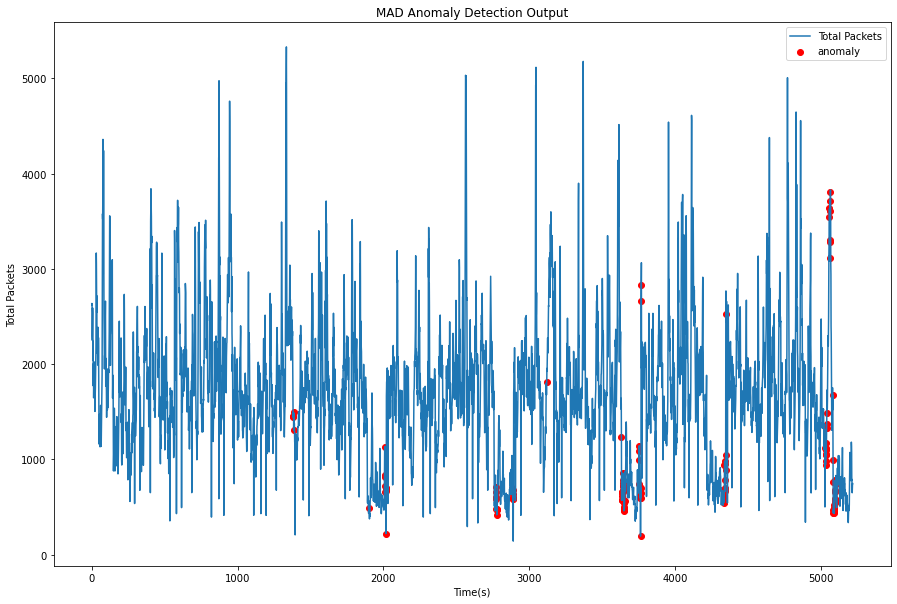

In [41]:
ma = df[df.madd==1]
plt.plot(df.total_pkts,label='Total Packets')
plt.scatter(ma.index,ma.total_pkts,color='r',label='anomaly')
plt.xlabel('Time(s)')
plt.ylabel('Total Packets')
plt.title('MAD Anomaly Detection Output')
plt.legend()
plt.savefig('output.png', dpi=300)


In [46]:
## Reading in Data + Feature generation + aggregation by 10 seconds
train_data=['40_40_5000_a.csv', '40_40_5000_b.csv', '40_40_5000_c.csv','40_40_5000_d.csv', '40_40_5000_e.csv','40_40_5000_m.csv','40_5000_160_1250_a.csv', '40_40_5000_f.csv', 
       '40_40_5000_g.csv', '40_5000_160_1250_b.csv','40_40_5000_h.csv', '40_40_5000_i.csv', '40_5000_160_1250_c.csv', '40_40_5000_j.csv', 
       '40_5000_160_1250_d.csv','40_40_5000_k.csv','40_40_5000_l.csv', '40_5000_160_1250_e.csv']
test_data = ['40_40_5000_n.csv','40_40_5000_o.csv','40_5000_320_1250_b.csv','40_40_5000_p.csv','40_40_5000_q.csv','40_40_5000_r.csv','40_5000_320_500_a.csv',
            '40_40_5000_s.csv','40_5000_320_1250_c.csv', '40_5000_320_1250_a.csv','40_5000_320_500_b.csv','40_5000_320_500_c.csv']
def aggregate_data(data, n):
    df = pd.DataFrame(pd.read_csv(data[0])[20:].reset_index().drop('index',axis=1))
    df['total_pkts'] = df['1->2Pkts'] + df['2->1Pkts']
    df = df[df['total_pkts'] >1].reset_index().drop('index',axis=1)
    df['label'] = data[0]
    for file in data[1:]:
        dff = pd.DataFrame(pd.read_csv(file)[20:]).reset_index().drop('index',axis=1)
        dff['total_pkts'] = dff['1->2Pkts'] +df['2->1Pkts']
        dff['label'] = file
        dff = dff[dff.total_pkts > 1].reset_index().drop('index',axis=1)
        df=  pd.concat([df,dff],ignore_index=True)
    df = df[:len(df) - (len(df) %n)]
    df_agg = pd.DataFrame([df[:n]['total_pkts'].mean(),df[:n].label.unique()[0]],index=['total_pkts','label']).T
    for i in range(n,df.shape[0],n):
        df_agg = pd.concat([df_agg,pd.DataFrame([df[i:i+n]['total_pkts'].mean(),df[i:i+n].label.unique()[0]],index=['total_pkts','label']).T],ignore_index=True)
    return df_agg,df
DF,df = aggregate_data(train_data,20)
test_df,dff = aggregate_data(test_data,20)

In [4]:
test_ = pd.concat([DF,test_df]).reset_index().drop('index',axis=1)


In [14]:
def eval_arima(X,arima_order,conf,n):
    train, test = X[:n], X[n:]
    history = [x for x in train]
    predictions = list()
    anomalies=[]
    upperLim=[]
    lowerLim=[]
    for t in range(n,len(test)+n):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        result = model_fit.get_forecast()
        conf_int = result.conf_int(alpha=conf)
        upperLim.append(conf_int[0,1])
        lowerLim.append(conf_int[0,0])
        if obs >= conf_int[0,0] and obs <= conf_int[0,1]:
            anomalies.append(0)
        else:
            anomalies.append(1)
    rmse = mean_squared_error(test, predictions, squared=False)
    return model_fit.aic,model_fit,test,predictions,anomalies,upperLim,lowerLim

def eval_models(dataset, p_vals,q_vals,d_vals, conf, n):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                order = (p,d,q)
                try:
                    aic,model_fit,test,predictions,anomalies,upperLim,lowerLim = eval_arima(dataset, order,conf,n)
                    best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
def plot_results(preds, data,anomalies, n, log=False):
    preds = pd.DataFrame(preds)
    preds['time'] = np.arange(n,len(preds)+n)
    preds= preds.rename({0:'preds'},axis=1).set_index('time')
    preds['anomaly'] = anomalies
    preds['actual'] =data.total_pkts[n:]
    anom = preds[preds.anomaly==1]
    if log == True:
        plt.plot(np.log(data.total_pkts.astype(float)),label='actual')
        plt.plot(preds.preds,label='preds')
        plt.scatter(anom.index,np.log(anom.actual.astype(float)),label='anomaly',c='r',s=100)
        plt.title('Anomaly Detection 40-5000-320-1250 (99% CI) - Log Scaled')
    if log == False:
        plt.plot(data.total_pkts,label='actual')
        plt.scatter(anom.index,anom.actual,label='anomaly',c='r',s=100)
        plt.title('Anomaly Detection 40-5000-320-1250 (99% CI))
    plt.legend()
    plt.xlabel('Time (10s)')
    plt.ylabel('Total Packets Sent')
    plt.savefig('output.png', dpi=300)
p_values = np.arange(1,4)
d_values = range(2)
q_values = np.arange(1,4)
# eval_models(np.log(DF.total_pkts), p_values, q_values, d_values, .01, 70)

In [32]:
rmse, model, test, preds,anomalies,upper,lower= eval_arima(np.log(DF.total_pkts.astype(float)), (3,0,2),.01,75)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


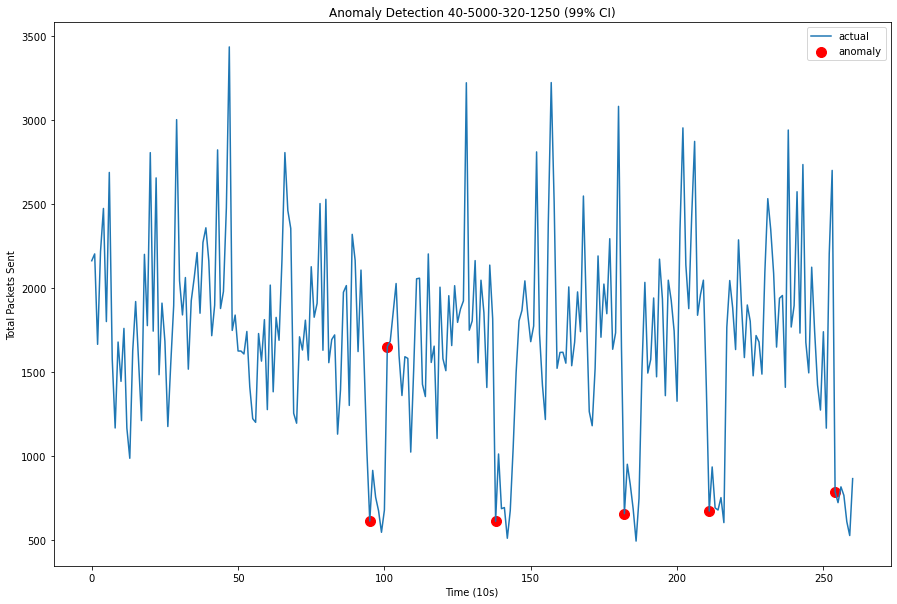

In [17]:
plot_results(preds,DF,anomalies,75)

In [18]:
rmse, model, test, preds,anomalies,upper,lower= eval_arima(np.log(test_.total_pkts.astype('float')), (3,0,2),.01,75)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


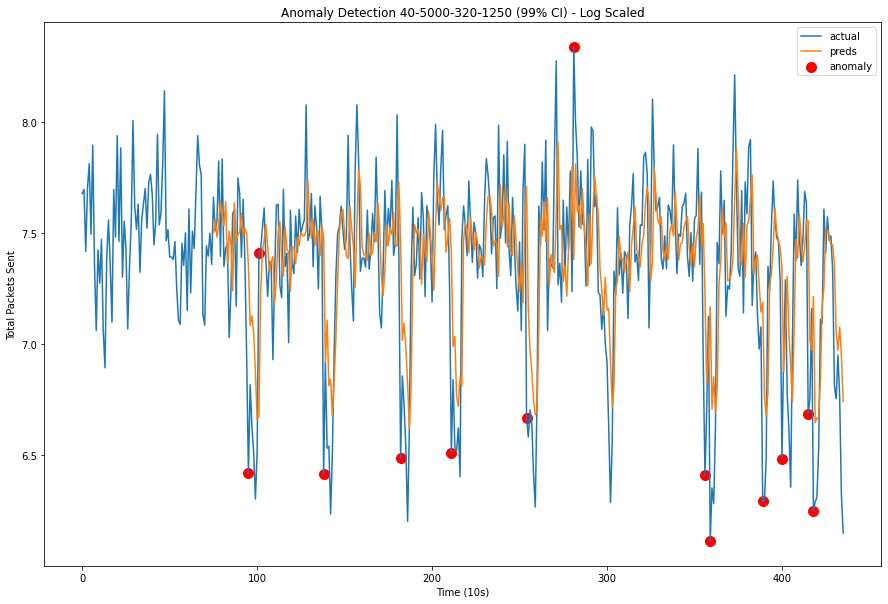

In [20]:
plot_results(preds,test_,anomalies,75,log=True)